In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
import scipy.optimize as op
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from IPython.display import set_matplotlib_formats

import tensorflow as tf

import pandas as pd
import rampy as rp

import sklearn
import sklearn.model_selection as model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor

from sklearn.externals import joblib

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
X_train= joblib.load("./data/X_train.pkl")
X_valid =joblib.load("./data/X_valid.pkl")
X_test =joblib.load("./data/X_test.pkl")

X_train_sc =joblib.load("./data/X_train_sc.pkl")
X_valid_sc = joblib.load("./data/X_valid_sc.pkl")
X_test_sc = joblib.load("./data/X_test_sc.pkl")

y_train = joblib.load("./data/y_train.pkl")
y_valid = joblib.load("./data/y_valid.pkl")
y_test = joblib.load("./data/y_test.pkl")

y_train_sc = joblib.load("./data/y_train_sc.pkl")
y_valid_sc = joblib.load("./data/y_valid_sc.pkl")
y_test_sc = joblib.load("./data/y_test_sc.pkl")

X_scaler = joblib.load("./data/X_scaler.pkl")
y_scaler = joblib.load("./data/y_scaler.pkl")

# Checking that it works. 

Should return the same results as the saving notebook as seed is fixed.

In [3]:
# parameters for neural net
prm_nn = dict(layers=(10,5,),solver = 'lbfgs',funct='relu',early_stopping=True)
param_b = dict(n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, verbose=0)

nn_train, nn_test, model_nn, X_scaler, y_scaler = rp.mlregressor(X_train,y_train,"BaggingNeuralNet",
                                                                 X_test=X_test, y_test=y_test, scaler = "StandardScaler",param_neurons=prm_nn,param_bagging=param_b,rand_state=100)



In [4]:
MSE_NN_train = np.sqrt(mean_squared_error(y_train, nn_train))
MSE_NN_test = np.sqrt(mean_squared_error(y_test, nn_test))

print("training and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_test)


training and testing RMSE with neural nets
0.3998124946991662
0.4518287509569338


(-3, 15)

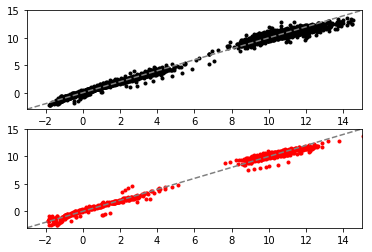

In [5]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_train, nn_train,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.subplot(2,1,2)
plt.plot(y_test, nn_test,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

# model with TensorFlow and A-G

The past example with scikit-learn directly relates the melt composition and temperature to it's viscosity.

The problem with this approach is that it underuses our knowledge of how viscosity and temperature vary.

This creates too much noise when predicting viscosity over T for one composition.

Illustration with the silica glass:

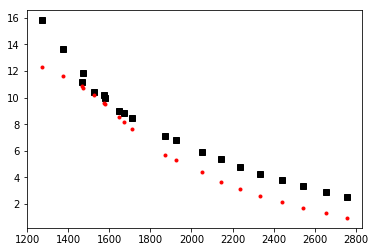

In [6]:
ex_input = X_train[X_train[:,0]==100.,:]
ex_y = y_train[X_train[:,0]==100.]
ex_pred = y_scaler.inverse_transform(model_nn.predict(X_scaler.transform(ex_input)))

plt.plot(ex_input[:,14],ex_y,"ks")
plt.plot(ex_input[:,14],ex_pred,"r.")



The predictions in red take a sort of sigmoidal shape which does not fit with the expected curvature observed in the data.

The solution to this problem is to fit not the viscosity directly, but the parameters of a viscosity equation with a neural net.

As we can use any equation, best if we can actually use the Adam and Gibbs one as it bring thermodynamic information on the melt.

If neural nets work, it should return an internally consistent model that should predict well the entropy and heat capacity of the melt.

Good thing is we know those values for some melts, such that we can trully quantify the success of the neural net.

$a^b$

The viscosity equation is:


$$log(\eta) = A_{e} + \frac{B_{e}}{T \times (S^{conf}(T_{g}) + \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT)}$$ 

where 

$$ \int_{T_{g}}^{T} \frac{\Delta C_p}{T} dT = ap \times (log(T) - log(T_{g})) + b \times(T-T_{g}) $$


$A_{e}$ is a constant proportional to the viscosity at infinite temperature. It barely depends on melt composition.

$B_{e}$ is a constant proportional to energy barriers opposed to viscous flow. It strongly depends on melt composition.

S^{conf}(T_{g}) is the configurational entropy of the melt at the glass transition temperature $T_g$ (temperature at which you consider that the melt becomes a glass.

$ap$ and $b$ are parameters that depend on melt composition. We have data and models for those; they nearly linearly depend on melt composition. (this can be discussed for b)

## Approach with neural net

The idea is to link the melt composition (14 variables) to the parameters $A_{e}$, $B_{e}$, $S^{conf}(T_{g})$, $ap$ and $b$ with a neural network.

We can calculate $T_{g}$ as 

$$ T_{g} = \frac{B_{e}}{((12.0-A_{e}) \times S^{conf}(T_{g}))} $$

with the empirical definition that $T_{g}$ occurs when the viscosity reaches around 12 log Pa $\cdot$ s.

This helps removing one parameter and should help to have a self-consistent model.

At this stage, we could use existing models for $ap$ and $b$, but there we assume that those models, which are 30 years old, are good-enough.

Another approach, which I adopt in the following, is to let the neural net determines $ap$ and $b$, such that we can compore those in the future with existing models.

If the neural net is good, we should find consistent results.

## Let's start

First I define the arrays that store the chemical composition and temperature.

viscosity (y values) are already saved in y_train/y_valid/y_test.

In [7]:
# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = X_train[:,0:14]
temperature_train = X_train[:,14].reshape(-1,1)

chimie_valid = X_valid[:,0:14]
temperature_valid = X_valid[:,14].reshape(-1,1)

chimie_test = X_test[:,0:14]
temperature_test = X_test[:,14].reshape(-1,1)

# rescale chimie between 0 and 1

chimie_train = chimie_train/chimie_train.sum(axis=1).reshape(-1,1)
chimie_valid = chimie_valid/chimie_valid.sum(axis=1).reshape(-1,1)
chimie_test = chimie_test/chimie_test.sum(axis=1).reshape(-1,1)

Following the reading of Kaufl, we will initiate the bias of the output neural net layer to values of parameters that are not far from reality.

In [8]:
init_bias = np.array([-4.5,np.log(80000.),np.log(10.1),np.log(10.),np.log(0.0001)]) # this code is actually in the object...

We then create an object to create a network with 1 to 5 layers (ReLu activation units + dropout),

feed results of output layer in the A-G equation (see above), and then initiate an optimizer (RMSprop seems the most stable from my test).

We use a L2 loss.

In [41]:
class Model(object):
    """
    derived from  https://github.com/adventuresinML/adventures-in-ml-code/blob/master/weight_init_tensorflow.py
    """
    def __init__(self, input_size, num_layers=3,
                 hidden_size=100,
                dropout = 0.1):
        self._input_size = input_size
        # num layers does not include the input layer
        self._num_layers = num_layers
        self._hidden_size = hidden_size
        self._out_size = 5 
        self._init_bias = np.array([-4.5,np.log(50000.),np.log(5.1),np.log(10.),np.log(0.0001)])
        self._dropout = dropout
        self._model_def()
    
    def _visco_out(self,T):
            return self.ae + self.be / (T * (self.sctg + (self.ap * (tf.log(T)-tf.log(self.tg)) + self.b * (T-self.tg))))
        
    def _calculate_variance(self, x):
        mean = tf.reduce_mean(x)
        sqr = tf.square(x - mean)
        return tf.reduce_mean(sqr)
    
    def _model_def(self):
        # create placeholder variables
        self.input_c = tf.placeholder(dtype=tf.float32, shape=[None,self._input_size], name="chimie")
        self.input_T = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T")
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="viscosity")

        if self._num_layers >= 1:
            
            self.Wh1 = tf.Variable(tf.random_normal([self._input_size,self._hidden_size], stddev=1e-3, dtype=tf.float32))
            self.bh1 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=1e-3, dtype=tf.float32))
            
            self.hidden_layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.input_c, self.Wh1) + self.bh1),
                                                keep_prob=1-self._dropout)
        
        if self._num_layers >= 2:
            
            self.Wh2 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=1e-3, dtype=tf.float32))
            self.bh2 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=1e-3, dtype=tf.float32))

            self.hidden_layer_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_1, self.Wh2) + self.bh2),
                                                keep_prob=1-self._dropout)
        
        if self._num_layers >= 3:
        
            self.Wh3 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=1e-9, dtype=tf.float32))
            self.bh3 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=1e-9, dtype=tf.float32))
            
            self.hidden_layer_3 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_2, self.Wh3) + self.bh3),
                                                keep_prob=1-self._dropout)
            
        if self._num_layers >= 4:
        
            self.Wh4 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=1e-9, dtype=tf.float32))
            self.bh4 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=1e-9, dtype=tf.float32))
            
            self.hidden_layer_4 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_3, self.Wh4) + self.bh4),
                                                keep_prob=1-self._dropout)
            
        if self._num_layers == 5:
        
            self.Wh5 = tf.Variable(tf.random_normal([self._hidden_size,self._hidden_size], stddev=1e-9, dtype=tf.float32))
            self.bh5 = tf.Variable(tf.random_normal([1,self._hidden_size], stddev=1e-9, dtype=tf.float32))
            
            self.hidden_layer_5 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.hidden_layer_4, self.Wh5) + self.bh5),
                                                keep_prob=1-self._dropout)

        self.Wo = tf.Variable(tf.random_normal([self._hidden_size,self._out_size], mean=0.,stddev=1e-3, dtype=tf.float32))
        self.bo = tf.Variable(tf.random_normal([1,self._out_size], mean=self._init_bias, stddev=self._init_bias*0.001, dtype=tf.float32))

        if self._num_layers == 1:
            self. output = tf.matmul(self.hidden_layer_1,self.Wo) + self.bo
        elif self._num_layers == 2:
            self. output = tf.matmul(self.hidden_layer_2,self.Wo) + self.bo
        elif self._num_layers == 3:
            self. output = tf.matmul(self.hidden_layer_3,self.Wo) + self.bo
        elif self._num_layers == 4:
            self. output = tf.matmul(self.hidden_layer_4,self.Wo) + self.bo
        elif self._num_layers == 5:
            self. output = tf.matmul(self.hidden_layer_5,self.Wo) + self.bo
        else:
            Print("Error: choose between 1 to 5 layers")
        
        #
        # Adam and Gibbs with network outputs
        #
        self.ae = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Ae")
        self.be = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Be")
        self.sctg = tf.placeholder(dtype=tf.float32, shape=[None,1], name="ScTg")
        self.ap = tf.placeholder(dtype=tf.float32, shape=[None,1], name="ap")
        self.b = tf.placeholder(dtype=tf.float32, shape=[None,1], name="b")
        self.visco_pred = tf.placeholder(dtype=tf.float32, shape=[None,1], name="visco_pred")
        
        self.ae, self.be, self.sctg, self.ap, self.b = tf.split(self.output,5,axis=1)

        # cannot be negative
        self.be = tf.exp(self.be)
        self.sctg = tf.exp(self.sctg)
        self.ap = tf.exp(self.ap)
        self.b = tf.exp(self.b)
        
        self.tg = self.be/((12.0-self.ae)*self.sctg)
        
        self.visco_pred = self.ae + self.be / (self.input_T * (self.sctg + (self.ap * (tf.log(self.input_T)-tf.log(self.tg)) + self.b * (self.input_T-self.tg))))
        
        self.loss = tf.nn.l2_loss(self.visco_pred-self.input_y)
                                                                            
        # add the loss to the summary
        tf.summary.scalar('loss', self.loss)
        self.optimizer = tf.train.RMSPropOptimizer(1e-4).minimize(self.loss)
        self.merged = tf.summary.merge_all()
        self.init_op = tf.global_variables_initializer()
        

Now we create our model object

In [42]:
NIN = chimie_train.shape[1]
NHIDDEN = 50
NLAYER = 2
STDEV = 0.01
DROP = 0.1

mod = Model(NIN, num_layers=NLAYER,hidden_size=NHIDDEN,dropout=DROP)

We start a TF Interactive Session to initiate our model, and look at the initial predictions.

The idea is to avoid starting the training with an initial model very far from reality...

So we run this cell again and again until we see a relatively close correspondance.

Initial predictions should be in a -5 - 20 range... If not, too much iterations are required for proper convergence...

We just avoid values at 10^20....

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


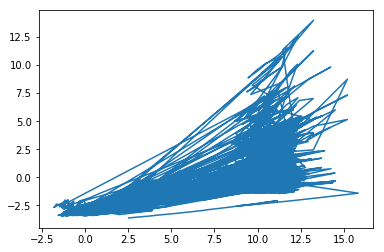

In [43]:
try:
    sess.close()
except:
    print("OK, no interactive session running")

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

pred_ini= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_train, 
                                             mod.input_T: temperature_train, 
                                             mod.input_y: y_train.reshape(-1,1)})
plt.figure()
plt.plot(y_train, pred_ini)

We then train the network for 50,000 iterations. We use the full batch. Should not be a problem as our dataset is relatively small.

Convergence is slow.

I do not perform early stopping (lines are commented) as it does not bring anything to the training. It stops the training too early.

Furthermore, good validation and testing errors are in general obtained because we use dropout, which favour generalization.

In [44]:
NEPOCH = 100
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.input_c: chimie_train, mod.input_T: temperature_train, mod.input_y: y_train.reshape(-1,1)}
    dct_valid = {mod.input_c: chimie_valid, mod.input_T: temperature_valid, mod.input_y: y_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]:
        count_es += 1
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 121608.796875, 25141.75390625


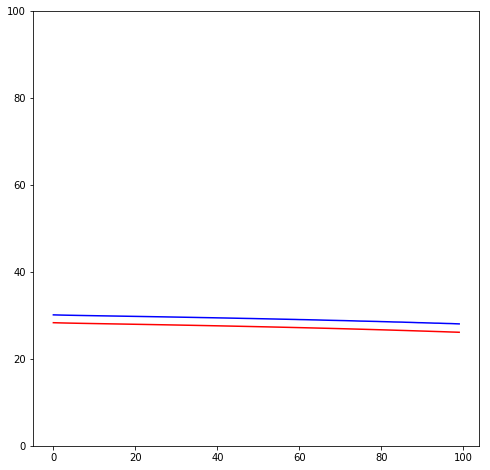

In [45]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(0, NEPOCH,1), loss_train/X_train.shape[0], 'r-')
plt.plot(np.arange(0, NEPOCH,1), loss_valid/X_valid.shape[0], 'b-')
plt.ylim(0,100)
plt.show()

Here this is supposed to save the model, which then can be re-used by tensorflow server...

In [48]:
tf.saved_model.simple_save(sess,
            "./model_test12/",
            inputs={"chimie": mod.input_c, "T": mod.input_T},
            outputs={"visco_pred": mod.visco_pred})
#saver = tf.train.Saver()
#saver.save(sess,'./model/tensorflowModel.ckpt')
#tf.train.write_graph(sess.graph.as_graph_def(), './model/', 'tensorflowModel.pbtxt', as_text=True)


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model_test12/saved_model.pb


We can make predictions by running the session calling mod.visco_pred.

However, I noticed that when you do that, TensorFlow still perturbates the Weigths and Bias fo the network so results slightly vary from one time to another...

(-3, 15)

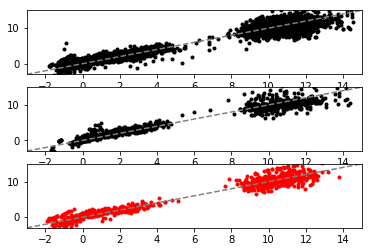

In [88]:
train_pred_out= sess.run(mod.visco_pred,feed_dict=dct_train)
plt.figure()
plt.subplot(3,1,1)
plt.plot(y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

valid_pred_out= sess.run(mod.visco_pred,feed_dict=dct_valid)
plt.subplot(3,1,2)
plt.plot(y_valid, valid_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

test_pred_out= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_test, 
                                              mod.input_T: temperature_test, mod.input_y: y_test.reshape(-1,1)})
plt.subplot(3,1,3)
plt.plot(y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

Errors are pretty good but this needs a lot of iterations. This current example is not optimal and could be further improved... Plus should be even better when finishing optimizing the network structure (less layers? more units? random selection?)

In [89]:
MSE_NN_train = np.sqrt(mean_squared_error(y_train, train_pred_out))
MSE_NN_valid = np.sqrt(mean_squared_error(y_valid, valid_pred_out))
MSE_NN_test = np.sqrt(mean_squared_error(y_test, test_pred_out))

print("training, validation and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_valid)
print(MSE_NN_test)

training, validation and testing RMSE with neural nets
1.091042220107328
1.3989605473765667
1.1262513495867665


Now we can compare with given compositions

In [90]:
#
dataset_post = pd.read_csv("./data/data_for_post_analyses.csv")

In [91]:
to_pred_c= dataset_post.loc[:,"sio2":"h2o"].values
to_pred_c = to_pred_c/to_pred_c.sum(axis=1).reshape(-1,1)
to_pred_c

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.5 , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.25, ..., 0.  , 0.  , 0.  ]])

In [92]:
print(to_pred_c)

[[1.   0.   0.   ... 0.   0.   0.  ]
 [1.   0.   0.   ... 0.   0.   0.  ]
 [1.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.5  0.   0.25 ... 0.   0.   0.  ]
 [0.5  0.   0.25 ... 0.   0.   0.  ]
 [0.5  0.   0.25 ... 0.   0.   0.  ]]


In [93]:
to_pred_T= dataset_post.loc[:,"T"]
to_pred_T.head()

0    2755.0
1    2655.0
2    2541.0
3    2441.0
4    2334.0
Name: T, dtype: float64

In [94]:
to_pred_n= dataset_post.loc[:,"viscosity"]
to_pred_n.head()

0    2.53
1    2.92
2    3.36
3    3.80
4    4.25
Name: viscosity, dtype: float64

In [95]:
visco_p, sctg_p, ap_p, b_p, tg_p  = sess.run([mod.visco_pred, mod.sctg, mod.ap, mod.b, mod.tg],
                        feed_dict={mod.input_c: to_pred_c, 
                                   mod.input_T: to_pred_T.values.reshape(-1,1), 
                                   mod.input_y: to_pred_n.values.reshape(-1,1)})

Text(0.5,1,'Measured vs Predicted Viscosity')

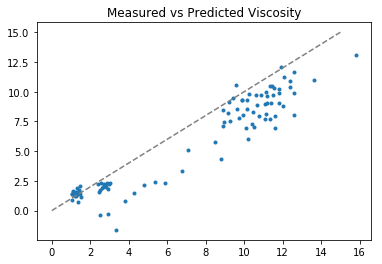

In [96]:
plt.plot(to_pred_n,visco_p,".")
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Viscosity")

Text(0.5,1,'Measured vs Predicted Entropy')

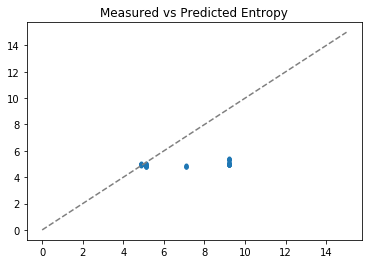

In [97]:
plt.plot(dataset_post.loc[:,"ScTg"],sctg_p,".")
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Entropy")

Text(0.5,1,'Measured vs Predicted Glass Transition Temperature')

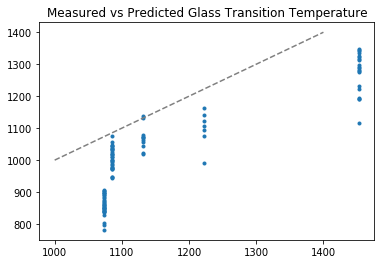

In [98]:
plt.plot(dataset_post.loc[:,"Tg"],tg_p,".")
plt.plot([1000,1400],[1000,1400],"--",color="grey")
plt.title("Measured vs Predicted Glass Transition Temperature")

True


'./models/data-all'

# OLD CODE: not used...


# trying with a TVF implementation

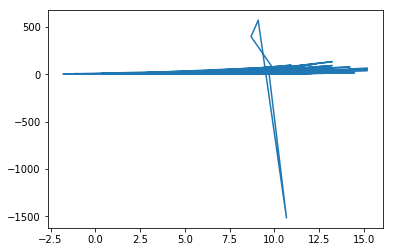

In [133]:
try:
    sess.close()
except:
    print("no session yet")

init_bias = np.array([-4.5,np.log(10000.),np.log(500.)])

NIN = chimie.shape[1]
NHIDDEN = 100
STDEV = 0.01
NOUT = 3 # A, B, T1 in TVF

c = tf.placeholder(dtype=tf.float32, shape=[None,NIN], name="chimie")
T = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="viscosity")

Wh1 = tf.Variable(tf.random_normal([NIN,NHIDDEN], stddev=1e-12, dtype=tf.float32))
bh1 = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1e-12, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], mean=0.,stddev=1e-10, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], mean=init_bias, stddev=init_bias*0.0001, dtype=tf.float32))

hidden_layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(c, Wh1) + bh1),keep_prob=0.9)

output = tf.matmul(hidden_layer_1,Wo) + bo

def get_ag_params(output):
    a = tf.placeholder(dtype=tf.float32, shape=[None,1], name="A")
    b = tf.placeholder(dtype=tf.float32, shape=[None,1], name="B")
    t1 = tf.placeholder(dtype=tf.float32, shape=[None,1], name="T1")
    
    a, b, t1 = tf.split(output,3,axis=1)

    # cannot be negative
    b = tf.exp(b)
    t1 = tf.exp(t1)

    return a, b, t1

a, b, t1 = get_ag_params(output)

def visco_out(a, b, t1, T):
    return a + b / (T - t1)

visco_pred = visco_out(a, b, t1, T)

lossfunc = tf.nn.l2_loss(visco_pred-y)
#lossfunc = tf.losses.mean_squared_error(visco_pred,y)

train_op = tf.train.AdamOptimizer().minimize(lossfunc)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

pred_ini= sess.run(visco_pred,feed_dict={c: chimie, T: temperature, y: y_train.reshape(-1,1)})
plt.figure()
plt.plot(y_train, pred_ini)

In [134]:
NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.

for i in range(NEPOCH):
    dct_train = {c: chimie, T: temperature, y: y_train.reshape(-1,1)}
    sess.run(train_op,feed_dict=dct_train)
    loss[i] = sess.run(lossfunc, feed_dict=dct_train)
    
    if (i % 500 == 0):
            print("Batch loss at step {}: {}".format(i, loss[i]))

Batch loss at step 0: 1441997.5
Batch loss at step 500: 12102.640625
Batch loss at step 1000: 8450.287109375
Batch loss at step 1500: 6179.3984375
Batch loss at step 2000: 5136.75732421875
Batch loss at step 2500: 4887.81982421875
Batch loss at step 3000: 4274.43603515625
Batch loss at step 3500: 4489.38330078125
Batch loss at step 4000: 3648.154296875
Batch loss at step 4500: 3215.80224609375
Batch loss at step 5000: 3205.978759765625
Batch loss at step 5500: 2891.554443359375
Batch loss at step 6000: 2700.7509765625
Batch loss at step 6500: 2592.109375
Batch loss at step 7000: 2505.94970703125
Batch loss at step 7500: 2473.9736328125
Batch loss at step 8000: 2442.663818359375
Batch loss at step 8500: 2223.05322265625
Batch loss at step 9000: 2227.984375
Batch loss at step 9500: 2077.270751953125


(-3, 15)

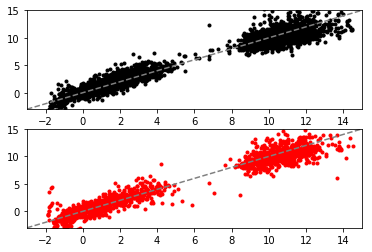

In [135]:
train_pred_out= sess.run(visco_pred,feed_dict={c: chimie, T: temperature, y: y_train.reshape(-1,1)})
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_train, train_pred_out,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

test_pred_out= sess.run(visco_pred,feed_dict={c: (X_test.iloc[:,0:14]).values, 
                                              T: X_test.iloc[:,14].values.reshape(-1,1), y: y_test.reshape(-1,1)})
plt.subplot(2,1,2)
plt.plot(y_test, test_pred_out,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

In [136]:
MSE_NN_train = np.sqrt(mean_squared_error(y_train, train_pred_out))
MSE_NN_test = np.sqrt(mean_squared_error(y_test, test_pred_out))

print("training and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_test)

training and testing RMSE with neural nets
0.9910742824828653
1.2025934001324372
